1. Data loading and cleaning
2. Object Detection
    1. Grounding DINO
2. Semantic segementation
    1. Segment Anything Model (SAM)
3. Image Captioning
    1. BLIP- ViT

In [10]:
# Load the data for detection --> fruit detection

import os
import numpy as np

image_list = np.random.choice(os.listdir(os.path.join('data/fruit_detection', 'images', 'valid')), 6)
image_list = [os.path.join('data/fruit_detection', 'images', 'valid', file) for file in image_list]

labels = [file.replace('.jpg', '.txt').replace('images', 'labels') for file in image_list]

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import json


def plot_samples(image_list, prediction, det_seg='detection'):
    
    with open('data/Teeth Segmentation JSON/obj_class_to_machine_color.json', 'r') as f: 
        colors = json.load(f)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i, (image, label) in enumerate(zip(image_list, prediction)):
        
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i//3, i%3].imshow(img)

        if det_seg == 'detection':
            for bbox, lab, conf in zip(np.array(label[0]['boxes'].cpu()), label[0]['text_labels'], np.array(label[0]['scores'].cpu())):

                x_min, y_min, x_max, y_max = bbox
                
                x, y = x_min, y_min
                w, h = (x_max - x_min), (y_max - y_min)

                rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2) 
                axs[i // 3, i % 3].add_patch(rect)

                axs[i// 3, i % 3].text(
                    x + w, y, lab, color='red', fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))

                axs[i// 3, i % 3].text(                             # Display the confidence
                    x, y, f'{conf:.2f}', color='red', fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))
        else:
            for pred in prediction[0]:
                tooth_label = int(pred.boxes.data.cpu().numpy()[0][5])
                mask = pred.masks.data[0].cpu().numpy()

                resized_mask = cv2.resize(mask, (pred.orig_shape[1], pred.orig_shape[0]), interpolation=cv2.INTER_NEAREST)
                polygon = np.transpose(np.array(resized_mask, dtype=np.uint8).nonzero())
            
                x = polygon[:, 1] 
                y = polygon[:, 0]

                color_rgb = np.array(colors[str(tooth_label)])/255  
            
                axs[i // 3, i % 3].fill(x, y, edgecolor = np.array(colors[str(tooth_label)])/255, fill=True, alpha = 0.6)

    plt.tight_layout()
    plt.show()

In [3]:
# Install transformers library directly from HuggingFace
#!pip install -q git+https://github.com/huggingface/transformers.git

### Object detection &rarr; Gounding Dino

/tmp/ipykernel_333437/3158892549.py:25: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = processor.post_process_grounded_object_detection(


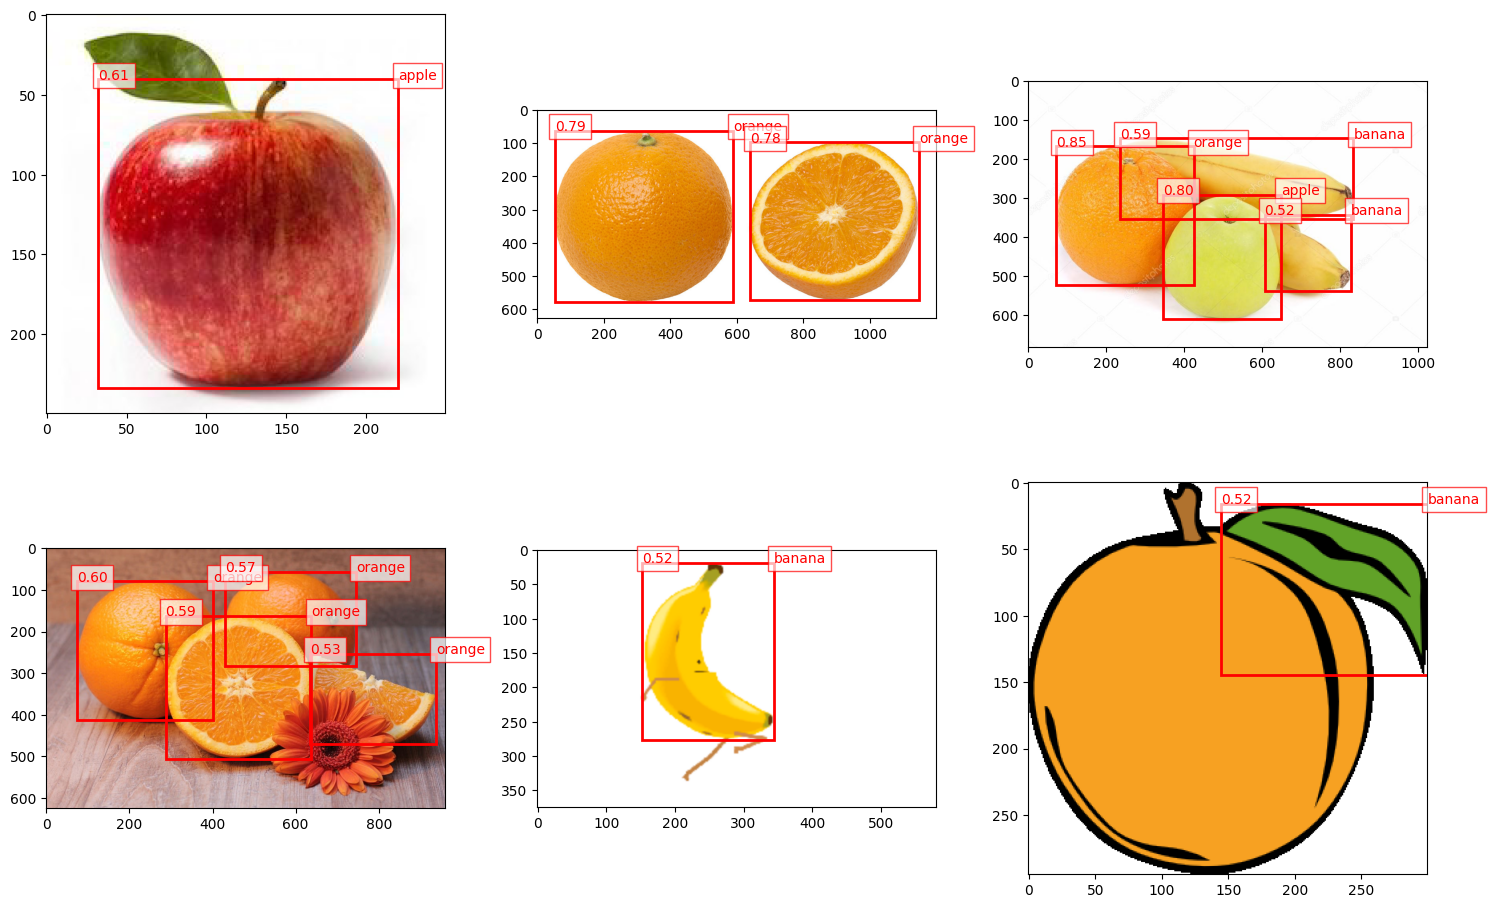

In [48]:
# Load Grounding DINO model
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection


model_id = "IDEA-Research/grounding-dino-base"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

pred_list = []

for image in image_list:

    text = "banana. apple. orange."
    
    image = Image.open(image).convert('RGB')
    inputs = processor(images=image, text=text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )
    pred_list.append(results)

plot_samples(image_list, pred_list, det_seg='detection')

### Semantic Segmentation &rarr; Segment Anything Model (SAM)

In [ ]:
%cd data/ # navigare to the data folder

!pip install 'git+https://github.com/facebookresearch/segment-anything.git' # install SAM model from repo

!mkdir data/weights # create a directory where to store the weights
%cd data/weights # navigate to that directory

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth # download the weights of the model

%cd ../../

[Errno 2] No such file or directory: 'data # navigare to the data folder'
/home/fabiotdt/Documents/rs_lab


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-v83eurso
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-v83eurso
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
/home/fabiotdt/Documents/rs_lab/data/weights


In [28]:
import matplotlib.pyplot as plt

def show_anns(anns, axs):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        axs.imshow(np.dstack((img, m*0.35)))
    
    plt.axis("off")
    plt.show()
    

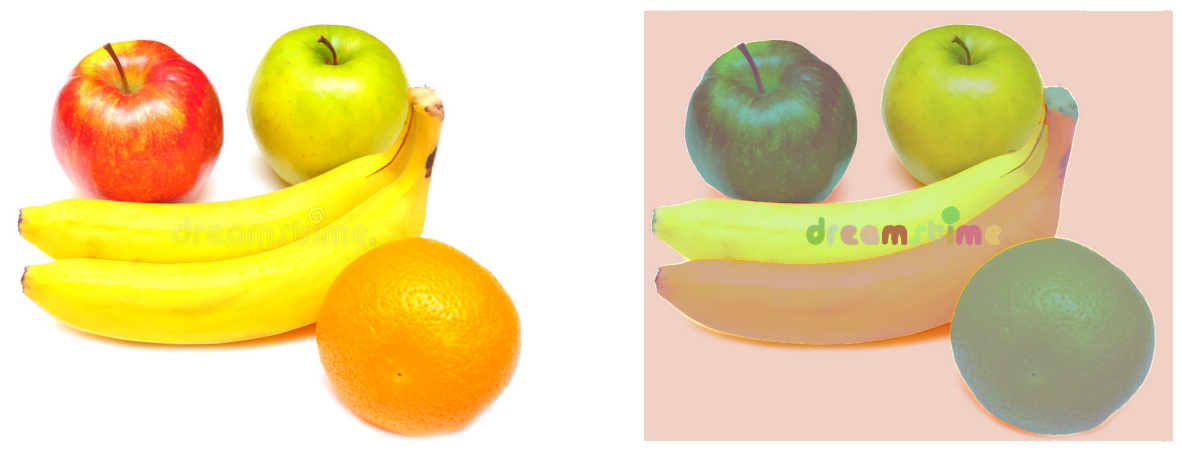

<Figure size 640x480 with 0 Axes>

In [33]:
import sys
sys.path.append("data/segment-anything/")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2

# Model specs
sam_checkpoint = "data/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda:0"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

image = cv2.imread('data/fruit_detection/images/valid/mixed_3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(image)
axs[0].axis("off")

axs[1].imshow(image)
show_anns(masks, axs[1])

plt.tight_layout()
plt.show()


In [ ]:
def load_bbox(file, image_shape):
    
    with open(file, 'r') as f:
        lines = f.readlines()
    boxes = []
    points = []

    w = image_shape[1]
    h = image_shape[0]
    
    for line in lines:
        lab, x_c, y_c, w_box, y_box = line.split() # The annotation is in the format: label, x_center, y_center, width, height

        boxes.append([(float(x_c)-float(w_box)/2)*float(w), (float(y_c) - float(y_box)/2)*float(h), (float(x_c)+float(w_box)/2)*float(w), (float(y_c)+float(y_box)/2)*float(h)])
        points.append([float(x_c)*float(w), float(y_c)*float(h)])


    return boxes, points

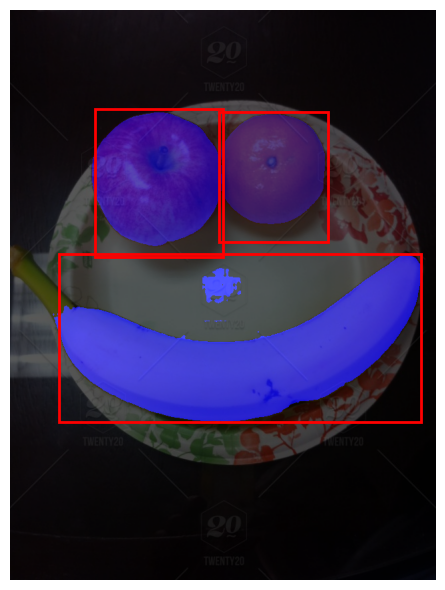

In [53]:
import sys
sys.path.append("data/segment-anything/")
from segment_anything import sam_model_registry, SamPredictor
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load weights and other parameters
sam_checkpoint = "data/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda:0"

# Load the model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

mask_list = []

#for img_name, label_name in zip(image_list, labels):

img_name = 'data/fruit_detection/images/valid/mixed_4.jpg'
label_name = 'data/fruit_detection/labels/valid/mixed_4.txt'
    
image = cv2.imread(img_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
boxes, points = load_bbox(label_name, image.shape[:2])
input_boxes = torch.FloatTensor(boxes).to(device)

input_points = torch.FloatTensor([[p] for p in points]).to(device)
input_label = torch.FloatTensor([[1]]*len(points))

predictor.set_image(image)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords=input_points, # Prompt center point of the bboxes
    point_labels=input_label, # Prompt labels of the point --> 1 for image, 0 for background
    boxes=transformed_boxes, # Prompt boxes
    multimask_output=False,
)

plt.figure(figsize=(6, 6))
#plt.imshow(image)
plt.axis('off')

overlay = image.copy()

for mask, bbox, point in zip(masks, boxes, points):
    
    x, y = bbox[0], bbox[1]
    w, h = bbox[2]-bbox[0], bbox[3]-bbox[1]
    
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2) 
    plt.gca().add_patch(rect)


    binary_mask = (mask.squeeze(0).cpu().numpy() > 0.5).astype(np.uint8) * 255 

    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 2] = binary_mask  # Set only red channel

    overlay = cv2.addWeighted(overlay, 0.7, mask_colored, 0.8, 0)

plt.imshow(overlay)
plt.tight_layout()
plt.show()



### Image Captioning with BLIP

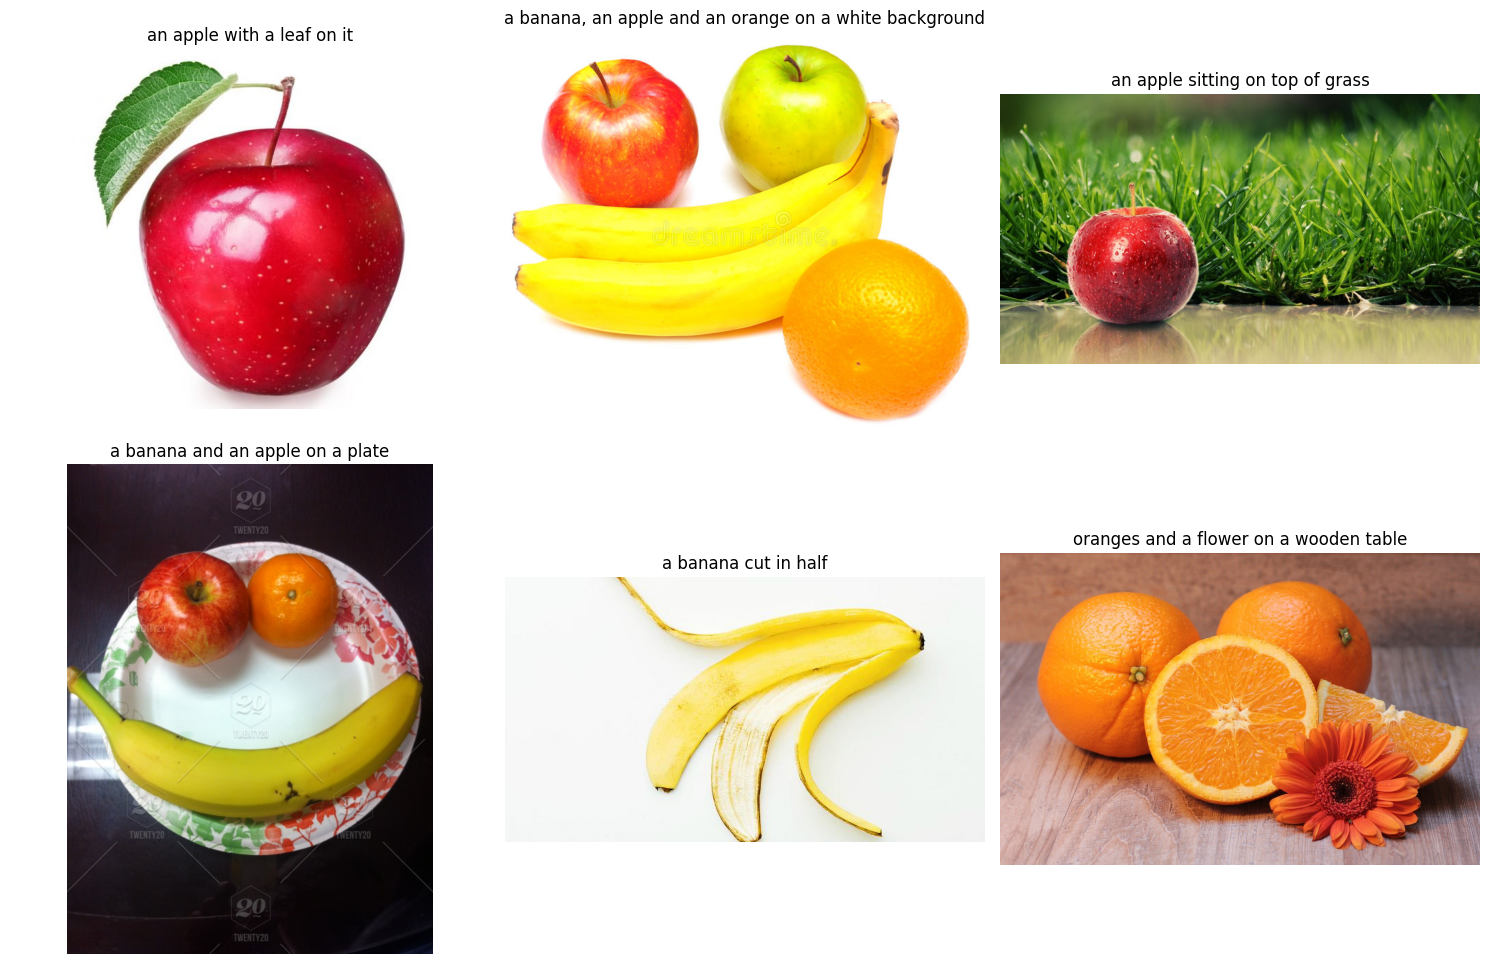

In [ ]:
# Image caption with BLIP

import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import cv2

device = 'cuda:0'

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


captions = []

for img_name in image_list:
    
    image = Image.open(img_name).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(**inputs)

    caption = processor.decode(output[0], skip_special_tokens=True)
    captions.append(caption)


fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (image, label) in enumerate(zip(image_list, captions)):
    
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i//3, i%3].imshow(img)

    axs[i//3, i%3].set_title(label)
    axs[i//3, i%3].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Zero shot segmentation with no annotation

# 1. Image caption with BLIP
# 2. Zero shot detection via caption prompt with Grounding DINO
# 3. Zero shot segmentation with SAM an bboxes from Grounding DINO 

import torch
import cv2
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoProcessor, AutoModelForZeroShotObjectDetection

class ZeroShotSegmentation():

    def __init__(self, BLIPmodel_id, DINOmodel_id, sam_checkpoint, model_type, device):
        
        self.BLIPprocessor = BlipProcessor.from_pretrained(BLIPmodel_id)
        self.BLIPmodel = BlipForConditionalGeneration.from_pretrained(BLIPmodel_id).to(device)

        self.DINOprocessor = AutoProcessor.from_pretrained(DINOmodel_id)
        self.DINOmodel = AutoModelForZeroShotObjectDetection.from_pretrained(DINOmodel_id).to(device)

        self.sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        self.sam.to(device=device)
        
        self.SAMpredictor = SamPredictor(self.sam)

        self.device = device

    def create_caption(self, image):
        
        inputs = self.BLIPprocessor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            output = self.BLIPmodel.generate(**inputs)

        caption = self.BLIPprocessor.decode(output[0], skip_special_tokens=True)
        return caption
    
    def object_detectio(self, image, text):

        inputs = self.DINOprocessor(images=image, text=text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.DINOmodel(**inputs)

        results = self.DINOprocessor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )
        return results

    def zero_shot_segmentation(self, image, bboxes):

        self.SAMpredictor.set_image(image)

        transformed_boxes = self.SAMpredictor.transform.apply_boxes_torch(bboxes, image.shape[:2])

        masks, _, _ = self.SAMpredictor.predict_torch(
            point_coords=bboxes[:, :2], # Prompt center point of the bboxes
            point_labels=torch.ones(len(bboxes)).to(self.device), # Prompt labels of the point --> 1 for image, 0 for background
            boxes=transformed_boxes, # Prompt boxes
            multimask_output=False,
        )

        return masks


In [ ]:
# Load everything

BLIP_model_id = "Salesforce/blip-image-captioning-base"
DINO_model_id = "IDEA-Research/grounding-dino-base"
sam_checkpoint = "data/weights/sam_vit_h_4b8939.pth"

model_type = "vit_h"
device = 'cuda:0'

zero_shot_segmentation = ZeroShotSegmentation(BLIP_model_id, DINO_model_id, sam_checkpoint, model_type, device)ù

# Run the pipeline

captions = []
predictions = []
masks = []

for img_name in image_list:
    
    image = Image.open(img_name).convert('RGB')
    caption = zero_shot_segmentation.create_caption(image)
    captions.append(caption)

    results = zero_shot_segmentation.object_detectio(image, caption)
    predictions.append(results)
    
    for bbox in results[0]['boxes']:
        bbox = torch.FloatTensor(bbox).to(device)

        mask = zero_shot_segmentation.zero_shot_segmentation(image, bbox)
        masks.append(mask)


plot_samples(image_list, predictions, det_seg='detection')

